## Compressing Data to the IoT Gateway using Autoencoders

Dataset: http://db.csail.mit.edu/labdata/labdata.html

The goal of this project is to reduce the amount of data sent to the gateway layer from edge devices. We use a dataset collected from Intel Labs, and attempt to reduce the size of the data into a form that is a representation of the original data. By reducing the amount of data sent from the sensor to the gateway, we can increase data throughput and decrease network latency.

### Data Loading

In [1]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with gzip.open('data.txt.gz', 'rb') as data_bytes:
    data = pd.read_csv(data_bytes, header=None, sep=' ', parse_dates=[[0, 1]], squeeze=True)
data.columns = ['DATETIME','EPOCH','MOTE_ID','TEMPERATURE','HUMIDITY','LIGHT','VOLTAGE']
data = data.set_index('DATETIME')
data.shape

(2313682, 6)

### Data Pre-processing

We will consider sensor data between March 1st and March 10th, resampled every 5 minutes. We will ignore the epoch column, as it does not provide any statistical relevance.

In [3]:
data_samp = data.drop('EPOCH', axis=1)
data_samp = data_samp.loc['2004-03-01':'2004-03-10']
data_samp.head()

,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
DATETIME,,,,,
2004-03-01 00:01:57.130850,1.0,18.4498,43.1191,43.24,2.67532
2004-03-01 00:02:50.458234,1.0,18.4400,43.0858,43.24,2.66332
2004-03-01 00:04:26.606602,1.0,18.4400,43.1191,43.24,2.65143
2004-03-01 00:05:28.379208,1.0,18.4498,43.0524,43.24,2.65143
2004-03-01 00:05:50.456126,1.0,18.4302,43.1525,43.24,2.66332


For the sake of out experiment, let us only consider sensors 1-10. We will drop sensors where Sensor_ID is NA, and make Sensor_ID an integer.

In [4]:
data_samp.dropna(subset=['MOTE_ID'], inplace=True)
data_samp.MOTE_ID = data_samp.MOTE_ID.astype(int)

data_samp = data_samp[(data_samp.MOTE_ID >= 1) & (data_samp.MOTE_ID <= 10)].copy()
print('Sensor_ID - Min: {}, Max: {}'.format(data_samp.MOTE_ID.min(), data_samp.MOTE_ID.max()))
data_samp.shape

Sensor_ID - Min: 1, Max: 10


(154618, 5)

Constructing a dataframe where Sensor_ID is the key. This will be more representative of inbound samples.

In [5]:
sensor_df = data_samp.set_index('MOTE_ID', append=True).unstack()

Resampling the dataframe every minute, excluding the MOTE_ID index.

In [6]:
sensor_df = sensor_df.resample('1min').mean()

Checking for empty data values...

In [7]:
sensor_df.isna().sum()

             MOTE_ID
TEMPERATURE  1           1673
             2           3693
             3           1652
             4           2693
             5          13507
             6           3611
             7            550
             8           4066
             9           1179
             10          1804
HUMIDITY     1           1673
             2           3693
             3           1652
             4           2693
             5          13507
             6           3611
             7            550
             8           4066
             9           1179
             10          1804
LIGHT        1           1673
             2           3693
             3           1652
             4           2693
             5          13507
             6           3611
             7            550
             8           4740
             9           2131
             10          1804
VOLTAGE      1           1673
             2           3693
             3     

Dropping Sensor_ID 5 since it appears to be missing every value.

In [8]:
sensor_df = sensor_df.T.drop(5, level='MOTE_ID')

Looking at missing data values, we can apply linear interpolation to fill in the missing values to complete our data set.

In [9]:
sensor_df = sensor_df.interpolate(method='linear', limit_direction='both', axis=0)

Reassign our transposed matrix to the original matrix.

In [10]:
sensor_df = sensor_df.T
sensor_df.describe()

TEMPERATURE                                                          \
MOTE_ID            1             2             3             4             6    
count    13507.000000  13507.000000  13507.000000  13507.000000  13507.000000   
mean        22.181167     22.158077     22.232428     22.203846     21.855226   
std          2.343358      2.046743      2.174981      2.051291      1.917945   
min         17.195400     17.464900     17.577600     17.680500     17.616800   
25%         20.637650     20.831200     20.782200     20.899800     20.605800   
50%         22.066000     22.242400     22.193400     22.056200     21.850400   
75%         23.768750     23.452700     23.673200     23.447800     23.199533   
max         28.681000     28.220400     28.269400     27.652000     27.213940   

                                                                     HUMIDITY  \
MOTE_ID            7             8             9             10            1    
count    13507.000000  13507.000000  13507.000000  13507.000000  13507.000000   
mean        21.841898     21.695400     21.853032     22.559221     36.003710   
std          1.959220      2.158277      2.316887      3.308306      5.502399   
min         17.499200     10.487300     17.396300     17.548200     21.565114   
25%         20.561700     20.204000     20.179500     20.537200     31.029433   
50%         21.742600     21.752400     21.811200     21.825900     36.577400   
75%         23.168500     23.006800     23.201167     24.065200     40.424350   
max         26.855260     30.502160     34.730040     39.093600     47.733800   

         ...         LIGHT       VOLTAGE                              \
MOTE_ID  ...            10            1             2             3    
count    ...  13507.000000  13507.000000  13507.000000  13507.000000   
mean     ...    241.672481     20.711778      6.254754      3.165763   
std      ...    268.866349     80.108533     31.107179     10.679782   
min      ...      0.878901      1.297802      1.716703      2.135604   
25%      ...     50.085715      2.616390      2.600569      2.616390   
50%      ...     75.440000      2.651430      2.627960      2.639640   
75%      ...    441.600000      2.687420      2.651430      2.669640   
max      ...   1478.415928   1109.471856    740.527784    465.208754   

                                                                               \
MOTE_ID            4             6             7             8             9    
count    13507.000000  13507.000000  13507.000000  13507.000000  13507.000000   
mean         2.723097      2.636697      2.640670      2.650242      2.696847   
std          4.180948      1.856831      0.534506      0.270067      0.041185   
min          2.368009      2.538120      2.560000      1.325538      2.560000   
25%          2.582260      2.571080      2.604910      2.616390      2.669320   
50%          2.610650      2.601120      2.633800      2.648880      2.699640   
75%          2.645535      2.627960      2.651430      2.675320      2.724400   
max        311.030943    156.853131     64.622222     33.685926      2.814790   

                       
MOTE_ID            10  
count    13507.000000  
mean         2.634631  
std          0.044625  
min          2.560000  
25%          2.599225  
50%          2.627960  
75%          2.651430  
max          2.814790  

[8 rows x 36 columns]

Unstacking the Sensor_ID brings it back to a column.

In [19]:
sensor_df = sensor_df.unstack(level=0)

In [20]:
sensor_df.index

MultiIndex([( 1, '2004-03-01 00:00:00'),
            ( 1, '2004-03-01 00:01:00'),
            ( 1, '2004-03-01 00:02:00'),
            ( 1, '2004-03-01 00:03:00'),
            ( 1, '2004-03-01 00:04:00'),
            ( 1, '2004-03-01 00:05:00'),
            ( 1, '2004-03-01 00:06:00'),
            ( 1, '2004-03-01 00:07:00'),
            ( 1, '2004-03-01 00:08:00'),
            ( 1, '2004-03-01 00:09:00'),
            ...
            (10, '2004-03-10 08:57:00'),
            (10, '2004-03-10 08:58:00'),
            (10, '2004-03-10 08:59:00'),
            (10, '2004-03-10 09:00:00'),
            (10, '2004-03-10 09:01:00'),
            (10, '2004-03-10 09:02:00'),
            (10, '2004-03-10 09:03:00'),
            (10, '2004-03-10 09:04:00'),
            (10, '2004-03-10 09:05:00'),
            (10, '2004-03-10 09:06:00')],
           names=['MOTE_ID', 'DATETIME'], length=121563)

In [22]:
test_df = sensor_df.iloc[sensor_df.index.get_level_values('MOTE_ID')==1]

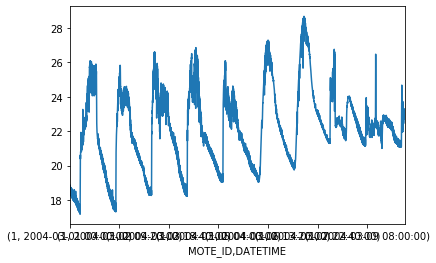

In [23]:
test_df.TEMPERATURE.plot()

In [21]:
sensor_df

TEMPERATURE    HUMIDITY       LIGHT   VOLTAGE
MOTE_ID DATETIME                                                          
1       2004-03-01 00:00:00     18.86630   35.186733  100.528133  36.72369
        2004-03-01 00:01:00     18.44980   43.119100   43.240000   2.67532
        2004-03-01 00:02:00     18.44000   43.085800   43.240000   2.66332
        2004-03-01 00:03:00     18.84180   37.120938  107.346400  29.11973
        2004-03-01 00:04:00     18.44000   43.119100   43.240000   2.65143
...                                  ...         ...         ...       ...
10      2004-03-10 09:02:00     24.69240   29.969100  507.840000   2.60491
        2004-03-10 09:03:00     29.13160  267.439900  924.976770   2.68742
        2004-03-10 09:04:00     24.71200   29.827100  507.840000   2.60491
        2004-03-10 09:05:00     24.70710   29.827100  507.840000   2.60491
        2004-03-10 09:06:00     29.27085  226.977900  866.091130   2.62796

[121563 rows x 4 columns]

In [15]:
#from keras.layers import Input, Dense
#from keras.models import Model

In [31]:
sensor_df.columns = sensor_df.columns.get_level_values(0)
sensor_df.head()

,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
DATETIME,,,,,
2004-03-01 00:00:00,1,18.8663,35.186733,100.528133,36.72369
2004-03-01 00:01:00,1,18.4498,43.119100,43.240000,2.67532
2004-03-01 00:02:00,1,18.4400,43.085800,43.240000,2.66332
2004-03-01 00:03:00,1,18.8418,37.120938,107.346400,29.11973
2004-03-01 00:04:00,1,18.4400,43.119100,43.240000,2.65143


In [16]:
#input_layer = Input(shape=(4,))
# "encoded" is the encoded representation of the input
#encoded = Dense(1, activation='relu')(input_layer)
# "decoded" is the lossy reconstruction of the input
#decoded = Dense(4, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
#autoencoder = Model(input_layer, decoded)

In [17]:
# autoencoder.summary()